In [98]:
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [99]:
df = pd.read_csv("df_cleaned.csv").iloc[:,1:]
# df = pd.read_csv("results_25022020.csv").iloc[:,1:]
# df = df[df.label.isin(['REJECTED', 'APPROVED'])]

In [100]:
df.groupby("label").size()

label
APPROVED    208
REJECTED     25
dtype: int64

In [101]:
y = df['label'].apply(lambda x: 1 if x == 'REJECTED' else 0)

In [102]:
X = df.iloc[:, 1:10]

In [103]:
# X = X.drop(['contact_us_score', 'tnc_score', 'broken_link_score', \
#             'link_contact_us_exist', 'link_about_us_exist', 'link_tnc_exist'], axis=1)

## Train/Test Split

In [104]:
X.columns

Index(['broken_link_score', 'link_contact_us_exist', 'cu_email_exist',
       'cu_phone_number_exist', 'link_about_us_exist', 'link_tnc_exist',
       'tnc_refund_policy_exist', 'contact_us_score', 'tnc_score'],
      dtype='object')

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=21)

In [106]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [107]:
y_pred = clf.predict(X_test)

In [108]:
y_pred_proba = clf.predict_proba(X_test)

In [109]:
accuracy_score(y_test, y_pred)

0.8311688311688312

In [110]:
y_test.value_counts()

0    69
1     8
Name: label, dtype: int64

In [111]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(62, 7, 6, 2)

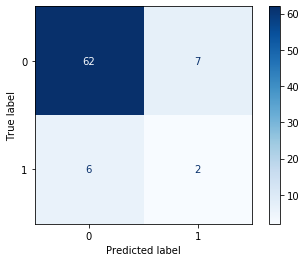

In [112]:
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [113]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

In [114]:
auc_score = auc(fpr, tpr)

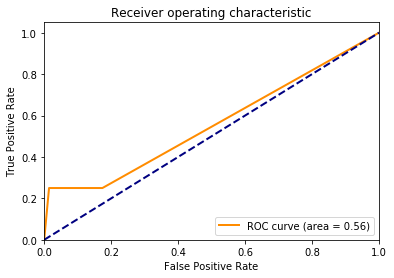

In [115]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [116]:
gini_score = abs(2 * auc_score) - 1
gini_score

0.1159420289855071

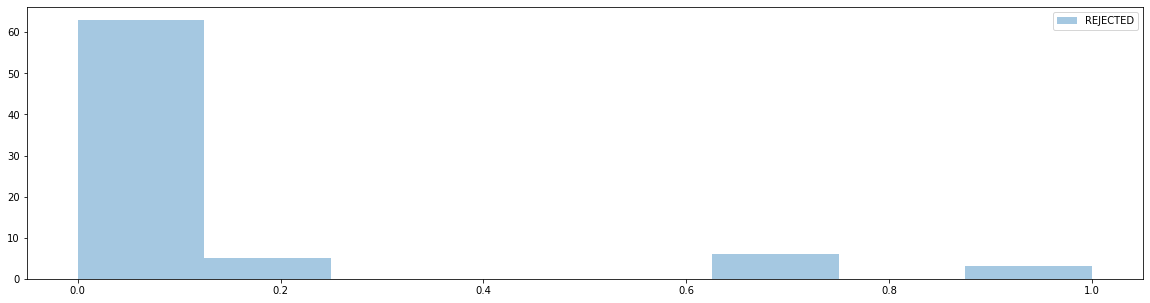

In [117]:
plt.figure(figsize=(20,5))
sns.distplot(y_pred_proba[:,1], kde=False, label='REJECTED')
plt.legend()
plt.show()

## Dump To Pickle

In [118]:
pickle.dump(clf, open('../models/final_prediction.pickle', 'wb'))

## Cross Validation

In [85]:
clf = tree.DecisionTreeClassifier()

In [86]:
cv_results = cross_validate(clf, X, y, scoring='roc_auc', cv=4)

In [87]:
sorted(cv_results.keys())

['fit_time', 'score_time', 'test_score']

In [88]:
cv_results['test_score']

array([0.86813187, 0.7724359 , 0.51762821, 0.65064103])

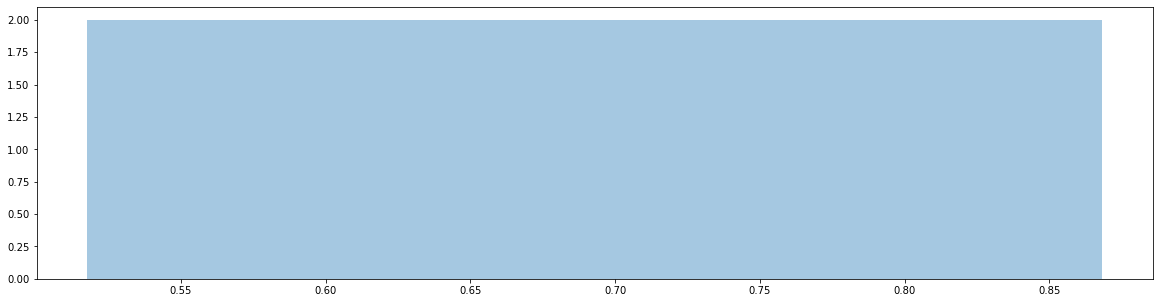

In [89]:
plt.figure(figsize=(20,5))
sns.distplot(cv_results['test_score'], kde=False)
plt.show()